In [1]:
# import all the libraries, that we will need in this notebook
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import copy
import matplotlib
import math
import random
from scipy.stats import f_oneway
import seaborn as sns
from adjustText import adjust_text

# 2 Preparing the dataset

In [2]:
# define a dictionary to map the emotion codes to the emotion names
emotions_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def get_information_from_f_name(f_name):
    """ function extracts the information from the file name:
    :param f_name: file name
    :return: dictionary with information about the file
    """
    # split the file name at the dashes
    f_name = f_name.split("-")
    # extract the information from each of the parts of the file name
    modality = "full-av" if f_name[0] == "01" \
        else "video only" if f_name[0] == "02" else "audio only"
    vocal_channel = "speech" if f_name[1] == "01" else "song"
    emotion = emotions_dict[f_name[2]]
    intensity = "normal" if f_name[3] == "01" else "strong"
    statement = "kids" if f_name[4] == "01" else "dogs"
    repetition = "1st" if f_name[5] == "01" else "2nd"
    actor = int(f_name[6].split(".")[0])
    gender = "m" if actor % 2 == 1 else "f"
    # return the information as a dictionary
    return {
        "vocal_channel": vocal_channel,
        "modality": modality,
        "emotion": emotion,
        "intensity": intensity,
        "statement": statement,
        "repetition": repetition,
        "actor": actor,
        "gender": gender
    }

# just a test to see if the function works
get_information_from_f_name("01-01-01-01-01-01-01.csv")

{'vocal_channel': 'speech',
 'modality': 'full-av',
 'emotion': 'neutral',
 'intensity': 'normal',
 'statement': 'kids',
 'repetition': '1st',
 'actor': 1,
 'gender': 'm'}

#### 2.1 Getting the file names for each subject / emotion

In [3]:
# get all the files in the data directory
files = os.listdir("data")

# create a dictionary to store the file names by emotion and by subject
filenames_by_emotion = {e: [] for e in emotions_dict.values()}
filenames_by_subject = {i: [] for i in range(1, 25)}

# loop over all the files
for f in files:
    # extract the information from the file name
    f_info = get_information_from_f_name(f)
    # add the file name to the corresponding list in the dictionaries
    filenames_by_emotion[f_info["emotion"]].append(f)
    filenames_by_subject[f_info["actor"]].append(f)

#### 2.2 and 2.3 Loading the data

In [4]:
def load_data_from_file(f_name):
    """ function loads the data from a file and returns it as a numpy array
    :param f_name: file name
    :return: numpy array with the data """
    # load the data from the file to a pandas dataframe
    data = pd.read_csv("data/" + f_name)
    # only keep the columns x_0, ... x_67 and y_0, ... y_67
    keep_columns = [f"x_{i}" for i in range(68)] + [f"y_{i}" for i in range(68)]
    data = data[keep_columns]
    # convert to numpy array
    data = data.to_numpy()
    return data

# just a test to see if the function works
test_data = load_data_from_file("01-02-01-01-01-01-01.csv")
test_data.shape

(126, 136)

In [5]:
def load_data_from_files(f_names):
    """ function loads the data from a list of files and returns it as a 3D numpy array
    of shape (n_samples, max_n_frames, n_features=136)
    :param f_names: list of file names
    :return: numpy array with the data """
    # prepare the lists to store the data and the emotions
    data = []
    emotions = []
    # loop over all the files
    for f_name in f_names:
        # load the data from the file and append it to the list
        data.append(load_data_from_file(f_name))
        # extract the emotion from the file name and append it to the list
        emotions.append(get_information_from_f_name(f_name)["emotion"])

    # find the maximum number of frames in all the data
    max_length = max([d.shape[0] for d in data])
    # pad the data with zeros
    padded_data = []
    for d in data:
        pad_length = max_length - d.shape[0]
        # pad the data with NaNs
        # check out the documentation at https://numpy.org/doc/stable/reference/generated/numpy.pad.html
        data_with_pad = np.pad(d, ((0, pad_length), (0, 0)), "constant",
                               constant_values=np.nan)
        padded_data.append(data_with_pad)
    # stack the data together to get a 3D numpy array
    # check out https://numpy.org/doc/stable/reference/generated/numpy.stack.html
    stacked_data = np.stack(padded_data)
    # return the data and the emotions as numpy arrays
    return stacked_data, np.array(emotions)

# test the function
happy_data, happy_emotions = load_data_from_files(filenames_by_emotion["happy"])
print(happy_data.shape, happy_emotions.shape)
print(happy_emotions[:10])

(376, 162, 136) (376,)
['happy' 'happy' 'happy' 'happy' 'happy' 'happy' 'happy' 'happy' 'happy'
 'happy']


In [6]:
# save the prepared data for all the videos and the emotions to a file,
# so that we don't have to do this again (it takes some time)
# """
all_files = os.listdir("data")
all_data, all_emotions = load_data_from_files(all_files)
np.save("all_data.npy", all_data)
np.save("all_emotions.npy", all_emotions)
# """


#### 2.4 and 2.5 Visualizing the data

(136,)
(136,)
(136,)
(136,)
(136,)
(136,)
(136,)
(136,)


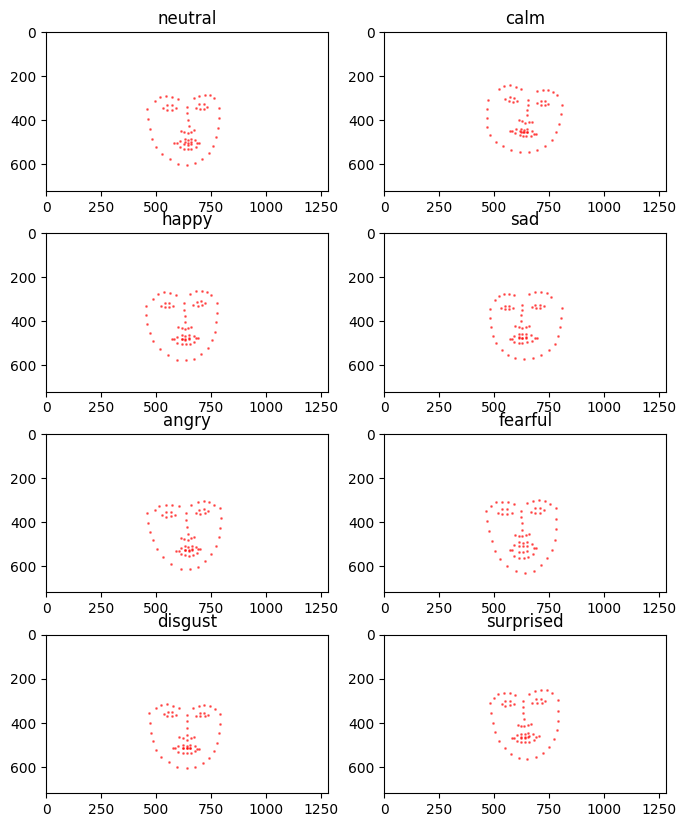

In [7]:
def visualize_frame(frame, ax, x_lim=(0, 1280), y_lim=(0, 720), color="r"):
    """ function visualizes a single frame of the video on the given axis """
    print(frame.shape)
    ax.scatter(frame[:68], frame[68:], c=color, s=1, alpha=0.5)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect("equal")
    ax.invert_yaxis()

# test the visualization, by plotting the first frame of the first video for each emotion
_, axs = plt.subplots(4, 2, figsize=(8, 10))
axs = axs.flatten()
for emotion, ax in zip(emotions_dict.values(), axs):
    # get the data for the emotion
    data, _ = load_data_from_files(filenames_by_emotion[emotion][:1])
    # plot the first frame of the first video
    visualize_frame(data[0, 0, :], ax)
    ax.set_title(emotion)

plt.show()

# 3 Outlier analysis and treatment
#### 3.1 Normalizing the data

In [9]:
def normalize_frame(frame):
    """ function normalizes a single frame of the video """
    x_ref, y_ref = frame[27], frame[68+27]
    x_max = 1280
    y_max = 720
    x_norm = (frame[:68] - x_ref) / x_max
    y_norm = (frame[68:] - y_ref) / y_max
    frame_norm = np.concatenate((x_norm, y_norm), axis=0)
    return frame_norm


In [10]:
# load the data from the file
data = np.load("all_data.npy")
emotions = np.load("all_emotions.npy")

normalized_data = np.apply_along_axis(normalize_frame, 2, data)

# reshape the data from (n_samples, max_n_frames, n_features=136)
# to (n_samples * max_n_frames, n_features=136), and remove the NaN frames after
normalized_data = normalized_data.reshape(-1, 136)
normalized_emotions = np.repeat(emotions, normalized_data.shape[0] / emotions.shape[0])


# remove the NaN frames and the corresponding emotions
normalized_emotions = normalized_emotions[~np.isnan(normalized_data).any(axis=1)]
normalized_data = normalized_data[~np.isnan(normalized_data).any(axis=1)]

print(normalized_data.shape, normalized_emotions.shape)

# save the normalized data to a file
np.save("normalized_data.npy", normalized_data)
np.save("normalized_emotions.npy", normalized_emotions)

(299854, 136) (299854,)


(136,)
(136,)


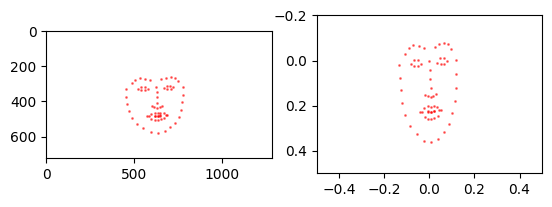

In [11]:
# plot the data to check if it is correct
_, axs = plt.subplots(1, 2)
visualize_frame(data[0, 0, :], axs[0])
visualize_frame(normalized_data[0, :], axs[1], x_lim=(-0.5, 0.5), y_lim=(-0.2, 0.5))


#### 3.2 Outlier analysis

In [12]:
# read the saved data
normalized_data = np.load("normalized_data.npy")
emotions = np.load("normalized_emotions.npy")
print(normalized_data.shape, emotions.shape)

(299854, 136) (299854,)


Text(0.5, 1.0, 'Values of variable 54 for each emotion')

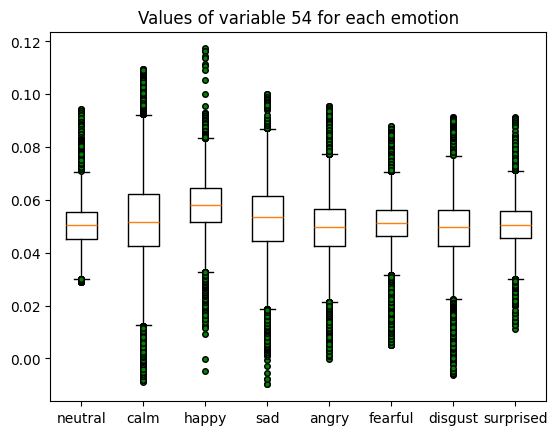

In [13]:
# create a dictionary with the values for chosen variable for each emotion
values_by_emotion = {}
chosen_variable = 54
for emotion in emotions_dict.values():
    emotion_data = normalized_data[emotions == emotion]
    values = emotion_data[:, chosen_variable]
    values_by_emotion[emotion] = values

# create a boxplot for the chosen variable
plt.boxplot([values_by_emotion[emotion] for emotion in emotions_dict.values()],
            labels=emotions_dict.values(), flierprops={'marker': 'o', 'markerfacecolor': 'g',
            'markersize': 4})
plt.title(f"Values of variable {chosen_variable} for each emotion")

#### 3.3 Density of outliers

Emotion    | Mean | Std  |
-----------|------|------|
neutral    | 1.20 | 1.70 |
calm       | 2.28 | 1.41 |
happy      | 1.87 | 1.11 |
sad        | 1.34 | 0.97 |
angry      | 2.08 | 0.98 |
fearful    | 2.74 | 1.56 |
disgust    | 2.62 | 1.94 |
surprised  | 1.99 | 1.83 |


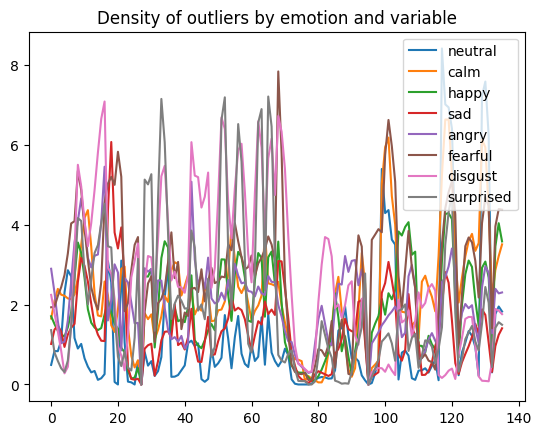

In [14]:
# get the number of outliers for each emotion
def density_of_outliers_by_emotion(emotion):
    all_variables = normalized_data[emotions == emotion]
    q1 = np.quantile(all_variables, 0.25, axis=0)
    q3 = np.quantile(all_variables, 0.75, axis=0)
    inter_quartile_range = (q3 - q1).reshape(1, -1)
    outliers_above = np.sum(all_variables > q3 + 1.5 * inter_quartile_range, axis=0)
    outliers_below = np.sum(all_variables < q1 - 1.5 * inter_quartile_range, axis=0)
    # count non nan values
    return (outliers_above + outliers_below) / len(all_variables) * 100


print("Emotion    | Mean | Std  |")
print("-----------|------|------|")
for emotion in emotions_dict.values():
    outlier_density = density_of_outliers_by_emotion(emotion)
    # create a such print:
    print(f"{emotion:10} | {np.mean(outlier_density):.2f} | {np.std(outlier_density):.2f} |")
    plt.plot(outlier_density, label=emotion)
plt.title("Density of outliers by emotion and variable")
plt.legend()

##### Comment on the results
We can observe that the emotions with the lowest mean of the density of outliers are neutral and sad, which intuitively makes sense, as these are the emotions where the face is most static. On the other side we see that fearful and disgust have more outliers.

It also looks like that there are more outliers in the first half of the plot, where the x variables are plotted, compared to the second half, where the y variables are plotted.


#### 3.4 and 3.5 Z-score test for identifying outliers

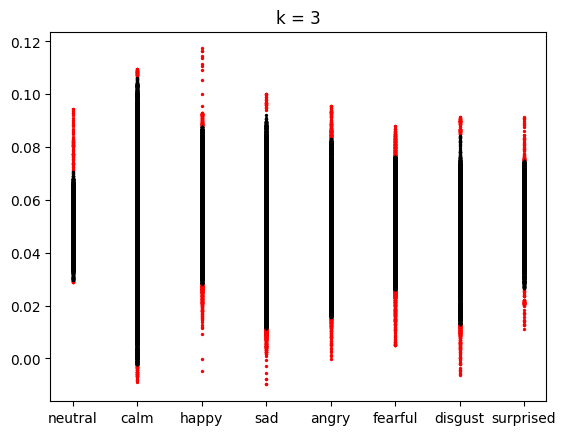

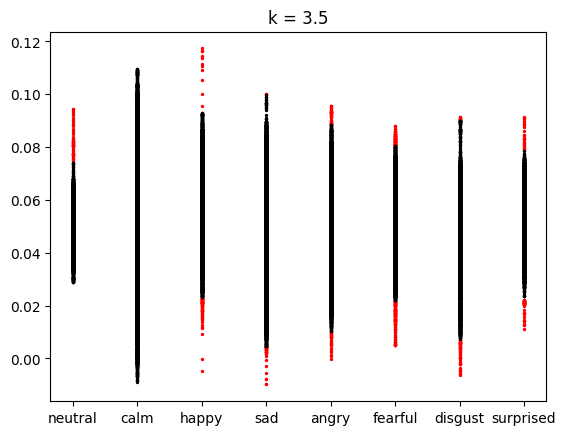

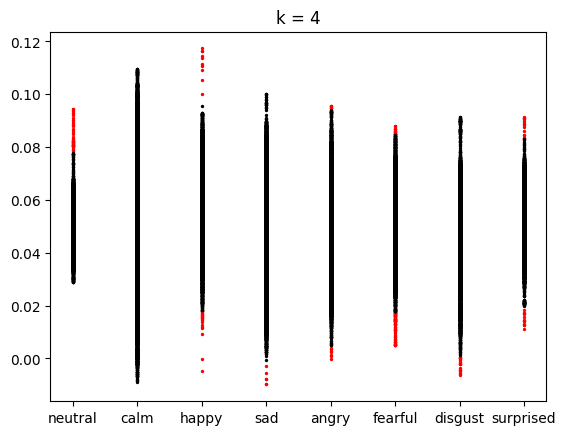

In [15]:
def identify_outliers(samples, k=3):
    """ function identifies the outliers using the z-score test"""
    z_scores = np.abs(stats.zscore(samples))
    return np.where(z_scores < k)[0], np.where(z_scores >= k)[0]

# select a variable
chosen_variable = 54

for k in [3, 3.5, 4]:
    for emotion in emotions_dict.values():
        emotion_data = normalized_data[emotions == emotion]
        # take the data of one variable and identify the outliers
        var_data = emotion_data[:, chosen_variable]
        not_outliers_idx, outliers_ixd = identify_outliers(var_data, k=k)
        injected_outliers = var_data[outliers_ixd]
        not_outliers = var_data[not_outliers_idx]

        # plot the outliers with red and not outliers with black
        plt.scatter([emotion] * len(injected_outliers), injected_outliers, c="r", s=2)
        plt.scatter([emotion] * len(not_outliers), not_outliers, c="k", s=2)

    plt.title(f"k = {k}")
    plt.show()


##### Compare the results in 3.2 and 3.5
The outliers calculated in 3.2 and 3.5 are similar, but not the same, as we use two different methods. For some emotions, there is a lot less outliers, when using the z-score test, for example for the emotion "calm", there is already very little outliers using k=3, and for k=4 there don't appear to be any outliers.

#### 3.7 K-means clustering

In [16]:
def k_means(points, n):
    """ function implements the k-means algorithm as described in the slides """
    # randomly select the n starting centers as n of the points
    center_indices = random.sample(list(range(len(points))), n)
    centers = []
    n_points = points.shape[0]
    for ci in center_indices:
        centers.append(tuple(points[ci]))

    while True:
        # copy the centers (we need to compare them later for stopping condition)
        old_centers = copy.deepcopy(centers)
        # create n empty clusters
        clusters = [[] for _ in range(n)]

        # create a num_points x num_centers matrix with the distances between each point and each center
        distances = np.zeros((len(points), n))
        for i, center in enumerate(centers):
            center = np.array([center])
            # compute distance between one center and all points
            distances[:, i] = np.linalg.norm(points - np.repeat(center, n_points, axis=0), axis=1)

        # for each point, find the closest center and add the point to the cluster of the center
        for i, point in enumerate(points):
            min_idx = np.argmin(distances[i, :])
            clusters[min_idx].append(point)

        # calculate new centers, by taking the mean of the points in the cluster
        centers = []
        for cluster in clusters:
            mean = np.mean(cluster, axis=0)
            centers.append(tuple(mean))

        if set(centers) == set(old_centers):
            return clusters


#### 3.8 Determine the outliers using k-means clustering

In [17]:
k = 12
# don't use all the data, as it takes too long
k_means_clusters = k_means(normalized_data[:20000, :], n=k)

In [18]:
# for each cluster measure the mean and std of distance from center to the points:
# consider all points that are far from the center to be outliers
outliers = []
for cluster in k_means_clusters:
    cluster = np.array(cluster)
    # calculate center:
    mean = np.mean(cluster, axis=0)
    # calculate the distances:
    distances = np.linalg.norm(cluster - np.repeat([mean], len(cluster), axis=0), axis=1)
    # calculate the mean and std of the distances:
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    # calculate the outliers:
    outliers.append(cluster[np.where(distances > mean_dist + 3 * std_dist)[0]])

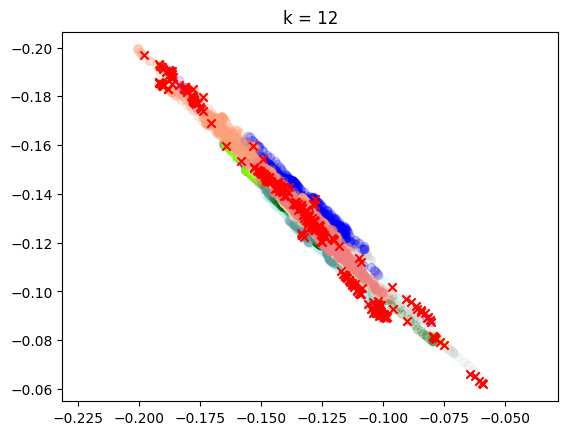

In [19]:
COLORS = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(COLORS)

# plot the clusters in 2D with different colors
fig, ax = plt.subplots()
# plot points and outliers
for i, cluster in enumerate(k_means_clusters):
    cluster = np.array(cluster)
    ax.scatter(cluster[:, 0], cluster[:, 1], color=COLORS[i], alpha=0.2, zorder=1)
    ax.scatter(outliers[i][:, 0], outliers[i][:, 1], color="red", marker="x", zorder=2)

ax.axis("equal")
ax.invert_yaxis()
ax.set_title(f"k = {k}")
plt.show()

#### 3.9 Inject outliers

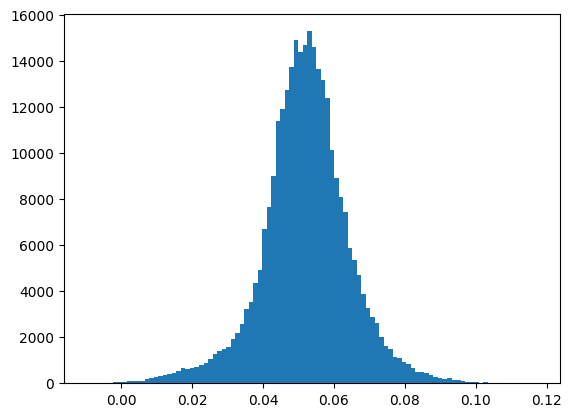

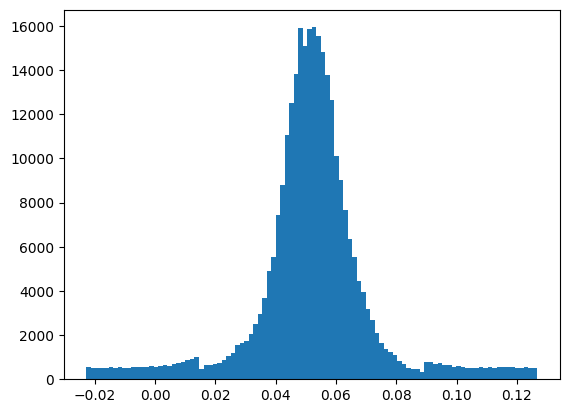

In [20]:
def inject_outliers(array, goal_density, k=3):
    array = copy.deepcopy(array)
    """ function injects outliers into the array, until the goal density is reached """
    non_outlier_idx, outliers_idx = identify_outliers(array, k=k)
    density = len(outliers_idx) / len(array) * 100

    if density < goal_density:
        density_diff = goal_density - density
        num_new_outliers = math.ceil(len(array) * density_diff / 100)
        mu = np.mean(array)
        sigma = np.std(array)

        # choose random indexes from the non outliers and replace them with outliers
        random_idx = np.random.choice(non_outlier_idx, size=num_new_outliers, replace=False)

        for idx in random_idx:
            s = random.choice([-1, 1])
            q = random.uniform(0, k * sigma)
            array[idx] = mu + s * k * sigma + s * q

    return array

# test the function:
variable_data = normalized_data[:, 54].flatten()
variable_data = variable_data[~np.isnan(variable_data)]

plt.hist(variable_data, bins=100)
plt.show()

variable_data = inject_outliers(variable_data, goal_density=10, k=3)
plt.hist(variable_data, bins=100)
plt.show()

#### 3.10 Linear model

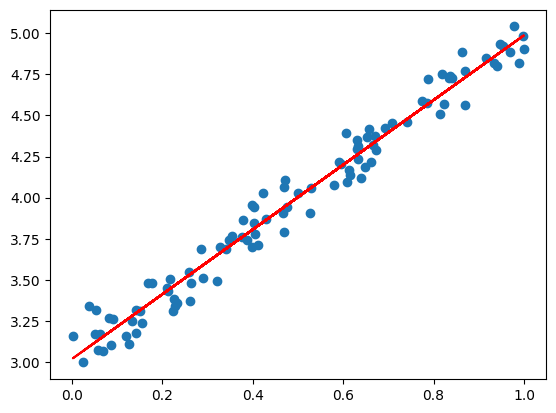

In [21]:
def linear_model(X, Y):
    # add a column of ones to X
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    # do SVD decomposition of X
    U, S, Vt = np.linalg.svd(X, full_matrices=False)

    S_inv = np.diag([1 / s if s > 1e-14 else 0 for s in S])
    X_plus = Vt.T @ S_inv @ U.T
    beta = X_plus @ Y

    return beta

# plot a simple 2d linear regression test
X = np.random.rand(100, 1)
Y = 2 * X + 3 + np.random.randn(100, 1) * 0.1
beta = linear_model(X, Y)

plt.scatter(X, Y)
plt.plot(X, beta[0] + beta[1] * X, c="r")
plt.show()

#### 3.11 Linear model for y coordinate 57

In [22]:
x = normalized_data[:, 57]
y = normalized_data[:, 57+68]
y_injected = inject_outliers(y, 5)

injected_outliers = y != y_injected
injected_outliers_indices = np.where(injected_outliers == True)[0]
print(injected_outliers_indices)

for p in range(1, 21):

    for idx in injected_outliers_indices:
        X = np.array(x[idx-p-1:idx-1]).reshape(-1, 1)
        Y = np.array(y_injected[idx-p-1:idx-1]).reshape(-1, 1)
        beta = linear_model(X, Y)
        y_injected[idx] = beta[0] + beta[1] * x[idx]

    true_values = y[injected_outliers]
    predicted_values = y_injected[injected_outliers]

    sum_of_squares_error = np.sum(np.power((true_values - predicted_values), 2))
    print(p, sum_of_squares_error)

[    38     73     90 ... 299806 299827 299847]


/var/folders/h5/qjt83gvx2_93d1cf9tvkktr80000gn/T/ipykernel_8515/3470936267.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_injected[idx] = beta[0] + beta[1] * x[idx]


1 1.1886933847287984
2 44.73399178828166
3 5.630285901390251
4 4.031575534598304
5 5.328852091230691
6 2.775029724294747
7 2.7096836119878844
8 2.7714880906733317
9 2.7900150664524492
10 2.745118966510023
11 2.7520813377339586
12 2.7808410299828004
13 2.7586972175558273
14 2.723702560212872
15 2.760330984579762
16 2.8703902755947053
17 3.134010945156584
18 3.4522215396305302
19 3.742394272945176
20 3.9922875495639114


#### 3.12 TODO

# 4. Feature selection

Load the data from files and normalize it, but for each video separately

In [23]:
# load the data from the file

data = np.load("all_data.npy")
emotions = np.load("all_emotions.npy")

normalized_data = np.apply_along_axis(normalize_frame, 2, data)

# save the normalized data to a file
np.save("normalized_data_by_videos.npy", normalized_data)
np.save("emotions_by_videos.npy", emotions)


In [24]:
# load the data from the file
normalized_data = np.load("normalized_data_by_videos.npy")
emotions = np.load("emotions_by_videos.npy")
print(normalized_data.shape)
print(emotions.shape)

(2452, 191, 136)
(2452,)


#### 4.1 EXTRACTING FEATURES

In [25]:
# helper functions (they all work on arrays also)

def calc_distance(x1, y1, x2, y2):
    """ calculates distance between points (x1, y1) and (x2, y2) """
    diff = np.vstack((x1 - x2, y1 - y2))
    return np.linalg.norm(diff, axis=0)

def calc_speed(x1, y1, x2, y2):
    """ calculates speed between points (x1, y1) and (x2, y2) """
    dist = calc_distance(x1, y1, x2, y2)
    return dist[:-1] - dist[1:]

def calc_triangle_area(x1, y1, x2, y2, x3, y3):
     """ calculates area of the triangle, defined by points (x1, y1), (x2, y2) and (x3, y3) """
     return abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2

def calc_angle(x1, y1, x2, y2):
    """ calculates the angle between horizontal line and line between points (x1, y1) and (x2, y2) """
    dx = x2 - x1
    dx[dx == 0] = 1e-10
    return np.arctan((y2 - y1) / dx)


##### 4.1.1 Defining landmarks & calculating statistical features

In [26]:
# calculate the features for landmarks
landmarks = [8, 18, 20, 23, 25, 30, 31, 35, 36, 45, 48, 51, 54, 57]
features = {}

for xy in ["x", "y"]:
    for landmark in landmarks:
        feature_name = f"mean_landmark_{landmark}_{xy}"
        features[feature_name] = []
        variable = landmark if xy == "x" else landmark + 68

        # calculate the features for each video
        for video in range(len(normalized_data)):
            data = normalized_data[video, :, variable]
            data = data[~np.isnan(data)]
            mean = np.mean(data)

            features[feature_name].append(mean)


In [27]:
# calculate the features for average distance, std distance and average speed between landmarks
pairs_of_points = [[31, 39], [35, 42], [38, 40], [43, 47],  [41, 48], [48, 54],
                   [46, 54], [62, 66], [51, 57], [20, 38], [23, 43], [1, 31], [15, 35]]

for points in pairs_of_points:
    x1 = points[0]
    x2 = points[1]
    y1 = x1 + 68
    y2 = x2 + 68

    features[f"mean_distance_{x1}_{x2}"] = []
    features[ f"std_distance_{x1}_{x2}"] = []
    features[f"mean_speed_{x1}_{x2}"] = []

    for video in range(len(normalized_data)):
        data = [normalized_data[video, :, variable] for variable in [x1, y1, x2, y2]]
        # remove nan values
        data = [d[~np.isnan(d)] for d in data]

        # calculate the distance between the points
        distance = calc_distance(data[0], data[1], data[2], data[3])
        speed = calc_speed(data[0], data[1], data[2], data[3])
        # calculate the features
        features[f"mean_distance_{x1}_{x2}"].append(np.mean(distance))
        features[f"std_distance_{x1}_{x2}"].append(np.std(distance))
        features[f"mean_speed_{x1}_{x2}"].append(np.mean(speed))


##### 4.1.2 Defining triangles & angles

In [28]:
triangles = [[18, 25, 30], [20, 23, 30], [48, 54, 30], [51, 57, 48], [51, 57, 54], [31, 35, 30],
             [36, 37, 41], [38, 39, 40], [37, 38, 40], [36, 37, 39]]

for points in triangles:
    x1 = points[0]
    x2 = points[1]
    x3 = points[2]
    y1 = x1 + 68
    y2 = x2 + 68
    y3 = x3 + 68

    features[f"triangle_area_{x1}_{x2}_{x3}"] = []

    for video in range(len(normalized_data)):
        data = [normalized_data[video, :, variable] for variable in [x1, y1, x2, y2, x3, y3]]
        # remove nan values
        data = [d[~np.isnan(d)] for d in data]
        triangle_area = calc_triangle_area(data[0], data[1], data[2], data[3], data[4], data[5])
        # calculate the features
        features[f"triangle_area_{x1}_{x2}_{x3}"].append(np.mean(triangle_area))

In [29]:
angles_vectors = [[18, 20], [23, 25], [48, 60], [54, 64], [51, 57]]

for points in angles_vectors:
    x1 = points[0]
    x2 = points[1]
    y1 = x1 + 68
    y2 = x2 + 68

    features[f"mean_angles_{x1}_{x2}"] = []
    features[f"std_angles_{x1}_{x2}"] = []

    for video in range(len(normalized_data)):
        data = [normalized_data[video, :, variable] for variable in [x1, y1, x2, y2]]
        # remove nan values
        data = [d[~np.isnan(d)] for d in data]

        # calculate the distance between the points
        angles = calc_angle(data[0], data[1], data[2], data[3])
        # calculate the features
        features[f"mean_angles_{x1}_{x2}"].append(np.mean(angles))
        features[f"std_angles_{x1}_{x2}"].append(np.std(angles))


#### 4.2 ANALYZE DISTRIBUTION AND STATISTICAL SIGNIFICANCE

In [30]:
# create a dataframe from the features
df = pd.DataFrame(features)
df["emotion"] = emotions
df.head()

# save the dataframe to a file
df.to_csv("features.csv", index=False)

In [31]:
# load the dataframe from a file
df = pd.read_csv("features.csv")

mean_df = df.groupby("emotion").mean()
mean_df.head(8)


,mean_landmark_8_x,mean_landmark_18_x,mean_landmark_20_x,mean_landmark_23_x,mean_landmark_25_x,mean_landmark_30_x,mean_landmark_31_x,mean_landmark_35_x,mean_landmark_36_x,mean_landmark_45_x,...,mean_angles_18_20,std_angles_18_20,mean_angles_23_25,std_angles_23_25,mean_angles_48_60,std_angles_48_60,mean_angles_54_64,std_angles_54_64,mean_angles_51_57,std_angles_51_57
emotion,,,,,,,,,,,,,,,,,,,,,
angry,0.001523,-0.094455,-0.049041,0.048024,0.091752,0.000820,-0.026212,0.026765,-0.083708,0.081251,...,0.017841,0.075728,-0.024677,0.073496,0.023829,0.147378,-0.168310,0.117903,0.253659,0.760276
calm,0.000308,-0.092875,-0.049517,0.049006,0.090914,0.000144,-0.026563,0.026358,-0.080825,0.079000,...,-0.226739,0.090367,0.209149,0.091513,0.023980,0.130653,-0.134914,0.114072,0.057141,0.573925
disgust,-0.000991,-0.090253,-0.046316,0.046023,0.089019,-0.000347,-0.028104,0.026837,-0.080827,0.079524,...,-0.013274,0.077565,0.043552,0.081152,0.082133,0.117590,-0.143966,0.097260,0.215456,0.781642
fearful,0.003198,-0.092056,-0.048158,0.047684,0.090924,0.000567,-0.025222,0.027021,-0.081806,0.081623,...,-0.142614,0.064904,0.136688,0.066590,-0.005469,0.109751,-0.149241,0.088779,0.580983,0.681168
happy,0.001093,-0.094868,-0.051381,0.049697,0.092328,0.000418,-0.028761,0.028607,-0.082483,0.080351,...,-0.181828,0.090344,0.166560,0.087435,0.188080,0.140815,-0.303348,0.121186,0.178625,0.877709
neutral,0.002375,-0.094033,-0.049935,0.048946,0.091445,0.000783,-0.024915,0.026297,-0.082138,0.080222,...,-0.161391,0.042903,0.132032,0.039017,-0.034213,0.090705,-0.118628,0.069875,0.387146,0.568051
sad,0.003843,-0.092483,-0.048264,0.046661,0.089497,0.001465,-0.025195,0.028074,-0.081611,0.080353,...,-0.166343,0.080361,0.126176,0.076830,0.079400,0.112258,-0.229747,0.094778,0.311655,0.532615
surprised,0.001782,-0.093447,-0.049584,0.048553,0.091178,0.000545,-0.025816,0.026815,-0.082300,0.080970,...,-0.075967,0.071276,0.072073,0.071464,0.040183,0.113020,-0.183324,0.091862,0.309507,0.739242


#### Kolmogorov-Smirnov test to check if the features are normally distributed

In [32]:
# do the kolmogorov-smirnov test for each feature and emotion and print p values in a nice table
#       | emotion 1 | emotion 2 | emotion 3 | ...
# feat1 | p value   | p value   | p value   | ...
# feat2 | p value   | p value   | p value   | ...
# ...
print("                           ", end="")
for emotion in df["emotion"].unique():
    print(f"{emotion[:6]:6} ", end="")

for feature in df.columns[:-1]:
    print(f"\n{feature:25}", end="")
    for emotion in df["emotion"].unique():
        data = df[df["emotion"] == emotion][feature]
        # standardize the data
        data = (data - np.mean(data)) / np.std(data)

        test = stats.kstest(data, "norm")
        p_value = test.pvalue

        print(f"{p_value > 0.05:7}", end="")


                           happy  angry  fearfu sad    disgus calm   neutra surpri 
mean_landmark_8_x              1      0      0      1      1      1      1      1
mean_landmark_18_x             1      1      0      0      1      1      1      1
mean_landmark_20_x             1      1      0      0      1      1      1      1
mean_landmark_23_x             1      1      1      1      1      1      1      1
mean_landmark_25_x             0      1      1      1      1      1      1      1
mean_landmark_30_x             1      1      1      1      1      1      1      0
mean_landmark_31_x             0      1      1      1      0      1      1      1
mean_landmark_35_x             1      1      1      1      1      1      1      1
mean_landmark_36_x             1      0      0      0      1      1      0      1
mean_landmark_45_x             0      1      1      1      1      1      1      1
mean_landmark_48_x             1      1      1      0      1      1      1      1
mean_landmark_

As not all features are normally distributed, we will apply ONE WAY ANOVA to understand whether the means of features are statistically different across the emotions.

In [33]:
# Iterate over each feature column
for feature_column in df.columns[:-1]:
    feature_groups = [df[df['emotion'] == emotion][feature_column].astype(float) for emotion in df['emotion'].unique()]

    # Perform ANOVA
    f_statistic, p_value = f_oneway(*feature_groups)

    # Display results for each feature
    print(f"\nANOVA for '{feature_column}':")
    print("F-statistic:", f_statistic)
    print("P-value:", p_value)

    if p_value < 0.05:
        print("The means are significantly different.")
    else:
        print("The means are not significantly different.")


ANOVA for 'mean_landmark_8_x':
F-statistic: 2.658240837688391
P-value: 0.009697519221114411
The means are significantly different.

ANOVA for 'mean_landmark_18_x':
F-statistic: 10.147742179140241
P-value: 1.4149145764634833e-12
The means are significantly different.

ANOVA for 'mean_landmark_20_x':
F-statistic: 25.980533716479822
P-value: 1.6590500942745847e-34
The means are significantly different.

ANOVA for 'mean_landmark_23_x':
F-statistic: 19.038866489184727
P-value: 6.603326378902729e-25
The means are significantly different.

ANOVA for 'mean_landmark_25_x':
F-statistic: 6.383038150475699
P-value: 1.850412100280045e-07
The means are significantly different.

ANOVA for 'mean_landmark_30_x':
F-statistic: 3.8228989047372015
P-value: 0.00038650383761222297
The means are significantly different.

ANOVA for 'mean_landmark_31_x':
F-statistic: 15.268923130326215
P-value: 1.1416269293256586e-19
The means are significantly different.

ANOVA for 'mean_landmark_35_x':
F-statistic: 7.1678290

#### 4.3 PCA

In [34]:
def PCA(features):
    """ Perform PCA on the features """
    # normalize the features
    P = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    PtP = np.dot(P.T, P)

    U, S, V = np.linalg.svd(PtP)

    print("num feat | explainability | cumulative")
    for i in range(min(30, len(S))):
        print(f"{i+1:9} | {S[i]/np.sum(S):14.2f} | {np.sum(S[:i+1])/np.sum(S):10.2f}")

    # calculate the principal components
    principal_components = np.dot(P, U)
    print(f"PCs shape: {principal_components.shape}")

    # scatter the first two principal components and color them by emotion
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=emotions)
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.gca().set_aspect('equal', 'datalim')

    return U, S, V, principal_components

num feat | explainability | cumulative
        1 |           0.18 |       0.18
        2 |           0.15 |       0.33
        3 |           0.10 |       0.43
        4 |           0.09 |       0.52
        5 |           0.07 |       0.59
        6 |           0.06 |       0.65
        7 |           0.05 |       0.70
        8 |           0.03 |       0.73
        9 |           0.03 |       0.76
       10 |           0.03 |       0.79
       11 |           0.02 |       0.81
       12 |           0.02 |       0.83
       13 |           0.02 |       0.85
       14 |           0.02 |       0.87
       15 |           0.01 |       0.88
       16 |           0.01 |       0.89
       17 |           0.01 |       0.90
       18 |           0.01 |       0.91
       19 |           0.01 |       0.92
       20 |           0.01 |       0.93
       21 |           0.01 |       0.94
       22 |           0.01 |       0.95
       23 |           0.01 |       0.95
       24 |           0.01 |       0.96
 

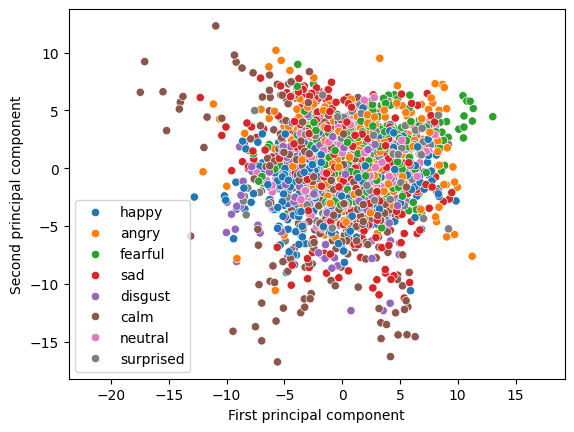

In [35]:
# perform PCA on the features
features_np = df.drop("emotion", axis=1).values
U, S, V, PC = PCA(features_np)

By visualizing the graph, we can observe that the features exhibit significant dispersion, indicating a wide range of values across the dataset. This dispersion suggests that the features do not follow a specific pattern or structure. Moreover, the data seem to assume some sphericity, implying that the distribution of points in the space is relatively uniform.

It's challenging to identify distinct clusters in the visualization, suggesting that the emotions may not be clearly separated in the space defined by the two main components. This lack of clear separation could imply that the selected features may not strongly contribute to the discrimination of emotions, and additional exploration or feature engineering may be necessary to enhance the model's ability to distinguish between different emotional states.
At last, we have to use 9 features to explain 75% of our the dataset.

#### Compression for a video of choice

In [36]:
video = 0
video_features = features_np[video, :]

video_features_pc = np.dot(video_features, U)
print(f"video features shape: {video_features[:15]}")

video features shape: [ 0.01019262 -0.09038524 -0.0470427   0.04377155  0.08391501  0.00476091
 -0.02307179  0.02905711 -0.07850283  0.07467807 -0.0501549   0.0043319
  0.056776    0.00611126  0.38224617]


#### 4.5 Fisher Score

In [37]:
# Fisher score:
# https://arxiv.org/ftp/arxiv/papers/1202/1202.3725.pdf

def fisher_score(features_df):
    """ Calculate the fisher score for each feature """
    feat = features_df.columns[:-1]

    mu = features_df.groupby("emotion").mean()
    mu_all = features_df[feat].mean()
    sigma_all = features_df[feat].std()
    N = features_df.groupby("emotion").count().iloc[:, 0]
    fisher_scores = {}

    for f in feat:
        mu_f = mu[f]
        mu_all_f = mu_all[f]
        sigma_all_f = sigma_all[f]

        fisher_scores[f] = (N * (mu_f - mu_all_f) ** 2).sum() / max((sigma_all_f ** 2), 1e-14)

    return fisher_scores


scores = fisher_score(df.copy())

#### Remove correlated features

In [38]:
def remove_correlated_features(df, scores):
    """ Remove features with high correlation """
    # sort the scores
    sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
    removed_features = []

    for i, feature in enumerate(sorted_scores):
        if feature in removed_features:
            continue
        for other_feature in list(sorted_scores)[i+1:]:
            # print(f"{feature} - {other_feature}")
            corr = np.corrcoef(df[feature], df[other_feature])[0, 1]
            if abs(corr) > 0.9:
                removed_features.append(other_feature)

    # remove the features with high correlation
    for feature in removed_features:
        sorted_scores.pop(feature)

    return sorted_scores

sorted_scores = remove_correlated_features(df, scores)
i = 0
top_10_scores = []
for feature in sorted_scores:
    top_10_scores.append(feature)
    print(f"{feature:22} | {sorted_scores[feature]:.2f}")
    i += 1
    if i == 10:
        break


mean_distance_38_40    | 877.91
mean_distance_48_54    | 856.20
mean_distance_62_66    | 753.65
std_distance_51_57     | 660.82
mean_distance_23_43    | 627.33
triangle_area_51_57_54 | 622.35
std_distance_48_54     | 582.47
triangle_area_51_57_48 | 543.81
mean_angles_18_20      | 525.17
mean_distance_46_54    | 480.04


After using the Fisher score, and removing highly correlated features, we should use the 10 features above.
We emphasize that these results align with the scientific literature, underscoring their robustness. In a 2021 study, Cai, Li, and Lu delved into various feature selection methods for emotion recognition, highlighting the importance of specific facial features—especially those related to the mouth and eyebrows—in achieving accurate recognition.
A couple of limitations are the lack of features in the nose, which might make it harder to identify emotions such as disgust. Some lack of symmetry in the eyebrows and eyes may pose challenges in capturing certain twitches expressions for some individuals.


In [39]:
from adjustText import adjust_text

def plot_landmarks(frame, landmarks):
    """ Plot the landmarks over the frame """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(frame[:68], frame[68:], c="b", s=4, alpha=1)
    texts = []
    ax.set_facecolor((1.0, 1.0, 1.0))

    # plot over the landmarks with red
    for landmark in landmarks:
        l = landmark.split("_")
        if l[1] == "landmark":
            ax.scatter(frame[int(l[2])], frame[int(l[2]) + 68], c="r", s=4, alpha=1)
            texts.append(ax.annotate(landmark, (frame[int(l[2])], frame[int(l[2]) + 68]),
                        fontsize=8))
        elif l[1] in ["distance", "angles"]:
            ax.plot([frame[int(l[2])], frame[int(l[3])]],
                    [frame[int(l[2]) + 68], frame[int(l[3]) + 68]], c="r", alpha=1)
            texts.append(ax.annotate(landmark, ((frame[int(l[2])] + frame[int(l[3])])/2,
                                   (frame[int(l[2]) + 68] + frame[int(l[3]) + 68])/2),
                        fontsize=8))

    adjust_text(texts, only_move={'points':'y', 'texts':'y'},
                arrowprops=dict(arrowstyle="->", color='g', lw=0.5))
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.show()



In [40]:
videos = np.load("all_data.npy")


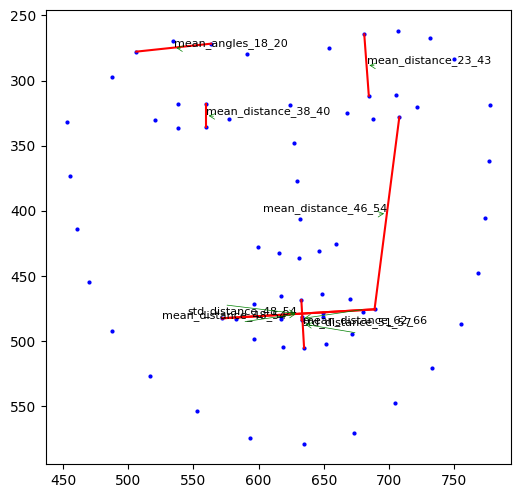

In [41]:
frame = videos[0][0]
plot_landmarks(frame, top_10_scores)


#### ReliefF

In [42]:
# implement ReliefF
# https://en.wikipedia.org/wiki/Relief_(feature_selection)

def ReliefF(features_df):
    """ Calculate the ReliefF score for each feature """
    feat = features_df.columns[:-1]
    num_feat = len(feat)
    num_instances = len(features_df)

    # calculate the distance between features in one line
    dist = np.zeros((num_instances, num_instances))
    features_np = features_df.drop("emotion", axis=1).values

    for i in range(num_instances):
        dist[i, :] = np.linalg.norm(features_np - features_np[i, :], axis=1)

    # calculate the nearest hit and nearest miss for each sample
    weights = np.zeros((len(features_df)))
    for idx in range(num_instances):
        emotion = features_df.iloc[idx, -1]

        # find the nearest hit and nearest miss
        nearest_hit = np.argmin(dist[idx, features_df["emotion"] == emotion])
        nearest_miss = np.argmin(dist[idx, features_df["emotion"] != emotion])

        # calculate the weight for each feature
        for j in range(num_feat):
            weights[j] = weights[j] \
                         - abs(features_df.iloc[idx, j] - features_df.iloc[nearest_hit, j]) \
                         + abs(features_df.iloc[idx, j] - features_df.iloc[nearest_miss, j])

    return weights / num_instances

weights = ReliefF(df)
weights = {k: v for k, v in zip(df.columns[:-1], weights)}

In [43]:
# sort the weights
sorted_weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse=True)}

top_10_weights = {}

i = 0
for feature in sorted_weights:
    top_10_weights[feature] = sorted_weights[feature]
    print(f"{feature:22} | {sorted_weights[feature]:.6f}")
    i += 1
    if i == 10:
        break

mean_angles_54_64      | 0.003313
mean_landmark_25_y     | 0.000389
mean_distance_43_47    | 0.000270
mean_distance_38_40    | 0.000261
mean_landmark_35_y     | 0.000093
std_distance_46_54     | 0.000088
std_distance_35_42     | 0.000064
std_distance_31_39     | 0.000045
std_distance_51_57     | 0.000036
triangle_area_20_23_30 | 0.000027


The advantages of this approach seem to lie in the diversification of features between the eyes, eyebrows, and mouth. In a sense, it could be more sensitive in capturing a broader range of emotions. However, there appears to be an overemphasis on the nose in these results, potentially beneficial for capturing the disgust emotion. Nevertheless, the lack of features in the mouth raises concerns about overall reliability. Striking a more balanced feature distribution could further enhance the robustness of our approach.

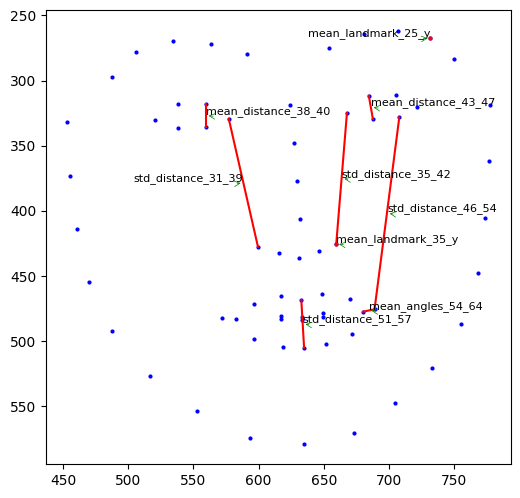

In [44]:
plot_landmarks(frame, top_10_weights)

